In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import backend as K
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

from keras.applications import VGG16
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Lambda, Dropout, SeparableConv2D, add
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
from PIL import Image
from tqdm import tqdm, trange

/home/skkulab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
nb_classes = 1  # number of classes
img_width, img_height = 64, 64  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
learn_rate = 1e-5  # sgd learning rate

train_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/train'
validation_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/validation'
test_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/test'

### AlexNet Model (64x64)

In [3]:
img_input = Input(shape=(img_height, img_width, 3))

x = Conv2D(96, 11, strides=4, padding='same', use_bias=False)(img_input) # 15
x = Activation('relu')(x)

x = Conv2D(256, 5, strides=1, padding='same', use_bias=False)(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8

x = Conv2D(384, 3, strides=1, padding='same', use_bias=False)(x) # 15
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8

x = Conv2D(384, 3, strides=1, padding='same', use_bias=False)(x) # 15
x = Activation('relu')(x)
x = Conv2D(256, 3, strides=1, padding='same', use_bias=False)(x)
x = Activation('relu')(x)

model_out = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Add fully connected layer
x = GlobalAveragePooling2D()(model_out)
x = Dense(4096, activation=None)(x)
x = Activatino('relu')(x)
x = Dense(1, activation=None)(x)
out = Activation('sigmoid')(x)

model = Model(img_input, out)
print(model.summary())
print(len(model.trainable_weights))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 96)        34848     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       614400    
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 384)         884736    
__________

In [5]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(len(model.trainable_weights))

9


### Preparing train, validation data

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=32,
                                                  shuffle=False,
                                                  class_mode='binary')

Found 251702 images belonging to 2 classes.
Found 28298 images belonging to 2 classes.
Found 33258 images belonging to 2 classes.


In [7]:
test_classes = test_generator.classes

len(test_classes[test_classes == 0])

16543

### Train model(weight unfreezed)

In [8]:
callback_list = [EarlyStopping(monitor='val_acc', patience=5),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]

In [89]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=20,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             callbacks=callback_list,
                             verbose=1)

Epoch 1/20
100/100 [==============================] - 93s 930ms/step - loss: 0.6864 - acc: 0.5841 - val_loss: 0.7591 - val_acc: 0.4997
Epoch 2/20
100/100 [==============================] - 91s 909ms/step - loss: 0.6339 - acc: 0.6009 - val_loss: 0.5996 - val_acc: 0.7357
Epoch 3/20
100/100 [==============================] - 93s 927ms/step - loss: 0.6059 - acc: 0.6663 - val_loss: 0.4676 - val_acc: 0.8237
Epoch 4/20
100/100 [==============================] - 92s 922ms/step - loss: 0.4546 - acc: 0.7959 - val_loss: 0.3350 - val_acc: 0.8584
Epoch 5/20
100/100 [==============================] - 91s 907ms/step - loss: 0.2995 - acc: 0.8775 - val_loss: 0.2296 - val_acc: 0.9118
Epoch 6/20
100/100 [==============================] - 91s 913ms/step - loss: 0.2810 - acc: 0.8984 - val_loss: 0.3455 - val_acc: 0.8591
Epoch 7/20
100/100 [==============================] - 92s 923ms/step - loss: 0.2180 - acc: 0.9241 - val_loss: 0.1842 - val_acc: 0.9313
Epoch 8/20
100/100 [==============================] - 9

In [90]:
model.save("alexnet_64x64.h5")

### Fine-Tune model(weight freezed)

In [9]:
model = load_model("alexnet_64x64.h5")
model.summary()

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 96)        34848     
_________________________________________________________________
activation_17 (Activation)   (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)       614400    
_________________________________________________________________
activation_18 (Activation)   (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)          

In [10]:
def generator(directory, batch_size=32):
    folder =  np.sort(os.listdir(directory))
    real_img = np.asarray(glob.glob(directory + '/' + folder[0]+'/*.png'))
    real_idx = np.arange(len(real_img))
    
    while 1:
        X1 = []
        X2 = []
        y = []
        
        if (len(real_idx) < batch_size):
            real_idx = np.arange(len(real_img))
            continue
        
        for _ in range(batch_size):
            if (len(real_idx) < batch_size):
                real_idx = np.arange(len(real_img))
                break
            random1 = np.random.choice(real_idx, 1, replace=False)
            real_idx = real_idx[~np.isin(real_idx, random1)]
            random2 = np.random.choice(real_idx, 1, replace=False)
            real_idx = real_idx[~np.isin(real_idx, random2)]
            img1 = Image.open(real_img[random1[0]]).convert("RGB")
            img2 = Image.open(real_img[random2[0]]).convert("RGB")
            img1 = img1.resize((img_width, img_height))
            img2 = img2.resize((img_width, img_height))
            X1.append(np.asarray(img1) / 255.)
            X2.append(np.asarray(img2) / 255.)
            y.append(np.array([0.]))

        X1 = np.asarray(X1)
        X2 = np.asarray(X2)
        y = np.asarray(y)
        yield [X1, X2], y
        
def generator_res(ft_dir, directory, batch_size=32):
    folder = np.sort(os.listdir(directory))
    real_img = np.asarray(glob.glob(ft_dir + '/' + '0' +'/*.png'))
    real_idx = np.arange(len(real_img))
    random1 = np.random.choice(real_idx, 1, replace=False)
    img = Image.open(real_img[random1[0]]).convert("RGB")
    img = np.asarray(img.resize((img_width, img_height))) / 255.
    fake_img = np.asarray(glob.glob(directory + '/' + folder[1] + '/*.png'))
    fake_idx = np.arange(len(fake_img))
    test_img = np.asarray(glob.glob(directory + '/' + folder[0] + '/*.png'))
    test_idx = np.arange(len(test_img))
    while 1:
        X1 = []
        X2 = []
        y = []
        if (len(fake_idx) < batch_size):
            fake_idx = np.arange(len(fake_img))
            continue
        
        for _ in range(batch_size):
            if np.random.random() < 0.5:
                if (len(fake_idx) < batch_size):
                    fake_idx = np.arange(len(fake_img))
                    break
                random2 = np.random.choice(fake_idx, 1, replace=False)
                fake_idx = fake_idx[~np.isin(fake_idx, random2)]
                X1.append(img)
                img2 = Image.open(fake_img[random2[0]]).convert("RGB")
                img2 = img2.resize((img_width, img_height))
                X2.append(np.asarray(img2) / 255.)
                y.append(np.array([1.]))
            
            else:
                if (len(test_idx) < batch_size):
                    test_idx = np.arange(len(test_img))
                    break
                random3 = np.random.choice(test_idx, 1, replace=False)
                test_idx = test_idx[~np.isin(test_idx, random3)]
                img2 = Image.open(test_img[random3[0]]).convert("RGB")
                img2 = img2.resize((img_width, img_height))
                X1.append(img)
                X2.append(np.asarray(img2) / 255.)
                y.append(np.array([0.]))

        X1 = np.asarray(X1)
        X2 = np.asarray(X2)
        y = np.asarray(y)
        yield [X1, X2], y

In [11]:
def manDist(x):
    result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
    return result

def euclidean_distance(inputs):
    assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v + 1e-7)), axis=1, keepdims=True))  

def contrastive_loss(y_true,y_pred):
    margin=1.0
    return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))

def siamese_acc(y_true, y_pred):
    return K.mean((K.equal(y_true, K.cast(y_pred > 0.4, K.floatx()))), axis=1)

def y_pred_prt(y_true, y_pred):
    return y_pred

def l2_normalize(x, axis=-1, epsilon=1e-7):
    y = K.max(K.sum(x ** 2, axis, keepdims=True), axis, keepdims=True)
    return x / K.sqrt(y + epsilon)

In [12]:
input_seq = Input(shape=(64, 64, 3))
ft_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/fine-tune'
ft_datagen = ImageDataGenerator(rescale=1./255)
ft_generator = test_datagen.flow_from_directory(ft_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=32,
                                                  shuffle=False,
                                                  class_mode='binary')

Found 1138 images belonging to 2 classes.


In [13]:
ft_model = Model(img_input, out)
ft_model.set_weights(model.get_weights())
for l in range(len(ft_model.layers) - 2):
    ft_model.layers[l].trainable = False

In [14]:
ft_model.summary()
ft_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 96)        34848     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       614400    
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 384)         884736    
__________

In [29]:
history_ft = ft_model.fit_generator(ft_generator, steps_per_epoch=100, epochs=5, callbacks=callback_list, verbose=1)

Epoch 1/5
100/100 [==============================] - 11s 114ms/step - loss: 0.1822 - acc: 0.9370
Epoch 2/5
  1/100 [..............................] - ETA: 5s - loss: 0.0605 - acc: 0.9688

/home/skkulab/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/skkulab/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


100/100 [==============================] - 11s 109ms/step - loss: 0.1570 - acc: 0.9410
Epoch 3/5
100/100 [==============================] - 11s 113ms/step - loss: 0.1407 - acc: 0.9441
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 0.1283 - acc: 0.9466
Epoch 5/5
100/100 [==============================] - 11s 113ms/step - loss: 0.1095 - acc: 0.9514


## Siamese modeling ##

In [15]:
model = load_model("alexnet_64x64.h5")
model.layers.pop()

In [16]:
base_model = Model(img_input, x)
base_model.set_weights(model.get_weights())
for l in range(len(base_model.layers) - 1):
    base_model.layers[l].trainable = False   

im_in = Input(shape=(img_width, img_height, 3))
x1 = base_model([im_in])
x1 = Activation('sigmoid')(x1)
feat_x = Lambda(lambda x: l2_normalize(x, axis=1, epsilon=1e-7))(x1)
feat_x = Dropout(0.0)(feat_x)

model_top = Model(inputs=[im_in], outputs=feat_x)
model_top.summary()

left_input = Input(shape=(img_width, img_height, 3))
right_input = Input(shape=(img_width, img_height, 3))

h1 = model_top(left_input)
h2 = model_top(right_input)
distance = Lambda(euclidean_distance)([h1, h2])
siam_model = Model(inputs=[left_input, right_input], outputs=distance)
siam_model.compile(loss='mse', optimizer=Adam(), metrics=[siamese_acc])
siam_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
model_3 (Model)              (None, 1)                 4802593   
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
Total params: 4,802,593
Trainable params: 4,097
Non-trainable params: 4,798,496
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                 

In [17]:
train_gen = generator(ft_dir, 64)
test_gen = generator_res(ft_dir, test_dir, 64)

In [18]:
# callback_list = [EarlyStopping(monitor='val_acc', patience=3),
#                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)]
output = siam_model.fit_generator(train_gen, steps_per_epoch=50, epochs=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
50/50 [==============================] - 18s 365ms/step - loss: 0.1717 - siamese_acc: 0.8237


### Evaluate pre-trained model

In [19]:
model = load_model("alexnet_64x64.h5")
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y_pred = predictions.copy()

In [20]:
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

In [21]:
predictions[np.isnan(predictions)] = 0
y_pred[np.isnan(y_pred)] = 0

In [22]:
true_classes = test_generator.classes

In [23]:
report = metrics.classification_report(true_classes, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     16543
           1       0.97      1.00      0.98     16715

    accuracy                           0.98     33258
   macro avg       0.98      0.98      0.98     33258
weighted avg       0.98      0.98      0.98     33258



[[15976   567]
 [   36 16679]]


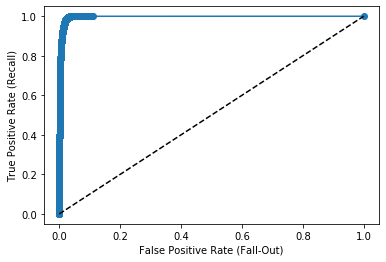

0.9817859652332542

In [24]:
fpr, tpr, thresholds = roc_curve(true_classes, y_pred, pos_label=1.)
cm = confusion_matrix(true_classes, predictions)
print(cm)
recall1 = cm[0][0] / (cm[0][0] + cm[0][1])
fallout1 = cm[1][0] / (cm[1][0] + cm[1][1])
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

plt.plot(fpr, tpr, 'o-')
plt.plot([0, 1], [0, 1], 'k--', label="random guess")

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

roc_auc_score(true_classes, predictions)

In [25]:
cm

array([[15976,   567],
       [   36, 16679]])

In [26]:
print("FPR=FAR", fallout1)
print("FNR=FRR", 1-recall1)

FPR=FAR 0.002153754113072091
FNR=FRR 0.03427431542041948


In [27]:
eer

0.020673396602225932

In [28]:
thresh

array(0.85710353)

In [29]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))
print('test acc:', test_acc)
print('test_loss:', test_loss)

test acc: 0.9818690239942269
test_loss: 0.05599299421299143


### Evaluate siamese model

In [30]:
score = []
answer = []
max_iter = int(16715 / 32)
j = 0
for i in tqdm(test_gen):
    if j == max_iter:
        break
    y_score = siam_model.predict_on_batch(i[0])
    score.append(y_score)
    answer.append(i[1])
    j += 1

522it [01:52,  4.44it/s]

In [31]:
score = np.concatenate(score)
answer = np.concatenate(answer)

In [38]:
fpr, tpr, thresholds = roc_curve(answer, score, pos_label=1.)
print(roc_auc_score(answer, score))
y_hat = score.copy()
y_hat[y_hat >= 0.7] = 1.
y_hat[y_hat < 0.7] = 0.
print(metrics.classification_report(answer, y_hat))
print(confusion_matrix(answer, y_hat))
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

0.9806055111741554
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     16547
         1.0       0.95      1.00      0.97     16815

    accuracy                           0.97     33362
   macro avg       0.97      0.97      0.97     33362
weighted avg       0.97      0.97      0.97     33362

[[15653   894]
 [    4 16811]]


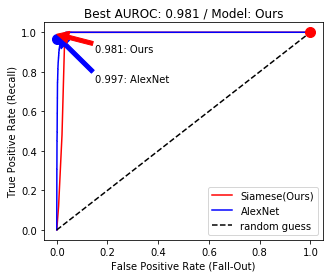

In [33]:
cm = confusion_matrix(answer, y_hat)
recall = cm[0][0] / (cm[0][0] + cm[0][1])
fallout = cm[1][0] / (cm[1][0] + cm[1][1])
fpr2, tpr2, thresholds2 = roc_curve(true_classes, y_pred, pos_label=1.)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, 'r-', label="Siamese(Ours)")
plt.plot(fpr2, tpr2, 'b-', label="AlexNet")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.plot([fallout1], [recall1], 'bo', ms=10)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title("Best AUROC: %.3f / Model: Ours" %(roc_auc_score(answer, score)))
plt.legend(loc='lower right')
plt.annotate("%.3f: AlexNet" %(roc_auc_score(true_classes, y_pred)), xy=(0.0, 0.98), xytext=(0.15, 0.75), arrowprops={'color':'blue'})
plt.annotate("%.3f: Ours" %(roc_auc_score(answer, score)), xy=(0.0, 0.99), xytext=(0.15, 0.9), arrowprops={'color':'red'})
plt.show()

In [34]:
print("FPR=FAR", fallout)
print("FNR=FRR", 1-recall)

FPR=FAR 1.0
FNR=FRR 0.0


In [35]:
eer

0.03169797023469449

In [36]:
thresh

array(0.77476154)

In [37]:
len(y_hat[np.equal(y_hat, answer)]) / len(y_hat)

0.49598345422936274

### Draw plot

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
plt.savefig('/home/skkulab/ICCV/models//xcetion_v1.png')

### Model train(weight unfreezed)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True


model.compile(optimizer=Adam(lr=learn_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(len(model.trainable_weights))

In [ ]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=nb_epoch,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             verbose=1)

In [ ]:
model.save('/home/skkulab/ICCV/models/xception_v2.h5')

### Draw plot

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Load trained model

In [ ]:
loaded_model = load_model('/home/skkulab/ICCV/models/xception_v1.h5')
loaded_model.summary()

### Preparing test data

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='binary')

In [ ]:
test_loss, test_acc = loaded_model.evaluate_generator(test_generator, steps=len(test_generator))
print('test acc:', test_acc)
print('test_loss:', test_loss)

In [ ]:
predictions = loaded_